In [1]:
# Imports
from IPython.display import Video
from tensorflow import keras
from tensorflow.keras import Sequential,Input,Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import LeakyReLU
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import skimage.measure
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2

# Project - Air drawing

---

90539 - Computer Vision

Laurea Magistrale - Computer science

Artificial Intelligence Track

University of Genova

---

Instructors:

- Francesca Odone

- Vito Paolo Pastore

---

Student: Arnaud Ruymaekers, S5298338

---

Instructions:

Design your alphabet, for instance some letters in italics since they trace continuous patterns:.

Acquire videos, use the VisionTool to learn detecting the tip of your finger, visualize the output by plotting the different features in one single plot. Can you read the message in the air?

Explore a strategy to extend the above method to words (including a visual encoding for spaces
between words)

## 0) Introduction

For this project, I will train a model to track the tip of my finger using the VisionTool application with a video. Then I will use this model to annotate a whole alphabet I drew in the air. Following this, I will attempt to feed it to a model trained at recognising handwritten letters to see if the letters of my alphabet are recognizable. And finally a word will be drawn in air to be analyzed, the letters will be drawn next to one another in order to minimize overlap.

## 1) Alphabet anotation

### 1.1) Annotation Model training

I trained a model on a video where a word is spelled out, it is to further track a finger for a full alphabet. The video used for the training of the model is the following:

In [2]:
Video("Videos/arnaud_4_h.mp4", width=300)

Note that video was mirrored due to the selfie mode of the camera used but this will be corrected by applying a horizontal mirroring of the annotated markers.

The annotation algorithm has been trained with the default NN settings, so a Linknet with Resnet50 backbone. It was trained on 50 annotations of the first video (so "arnaud") with a batch size of 1 and training rate of 0.001. The best validation iou score gotten with this technique was a 0.25 but it led to a very good prediction extending, not only to the rest of the video, but also to a second video shot in a similar way.

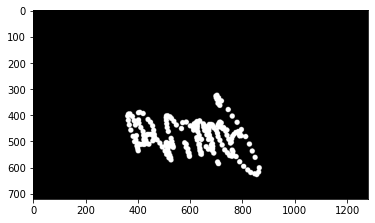

In [3]:
arnaud_annot = np.genfromtxt('Video_annotations/Annotation_arnaud_4_h.mp4_arnaud.csv', delimiter=',')[3:,1:]

# Video parameters
vid = cv2.VideoCapture('Videos/arnaud_4_h.mp4')
height = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))

# Flipping the annotations in the right orientation
arnaud_annot  = (0, height) - arnaud_annot

# Displaying a concatenation of all the markers in one single image.
arnaud_reconstruction = np.zeros((height,width))
x = np.arange(width)
y = np.arange(height)
marker_width = 10

for point in arnaud_annot[:,:]:
    cx = point[0]
    cy = point[1]
    mask = (x[np.newaxis,:]-cx)**2 + (y[:,np.newaxis]-cy)**2 < marker_width**2
    arnaud_reconstruction[mask] = 255
    
plt.imshow(arnaud_reconstruction, cmap='gray')
plt.show()

We can see that the no individual letter can really be distinguished here due to how the video was shot. But the point of this image is to show that no marker fall out of line from the rest so the prediction was fairly successfull

### 1.2) Alphabet annotation prep

Now at this step, based on a video where I speel out all the letters, I will split each letter into a set of marker in order to have a dataset to see if a neural network can predict what letters I was drawing.

In [4]:
alphabet_annot = np.genfromtxt('Video_annotations/Annotation_alphabet.mp4_arnaud.csv', delimiter=',')[3:,1:]

# Filtering out the frames that didn't have a prediction
alphabet_annot = alphabet_annot[np.any(alphabet_annot != (-1, -1), axis=1)]

# Flipping the annotations in the right orientation
alphabet_annot  = (0, height) - alphabet_annot

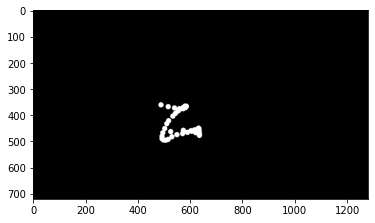

In [5]:
# Displaying a concatenation of all the markers in one single image.
alphabet_reconstruction = np.zeros((height,width))
x = np.arange(width)
y = np.arange(height)
marker_width = 10

for point in alphabet_annot[1680:1720,:]:
    cx = point[0]
    cy = point[1]
    mask = (x[np.newaxis,:]-cx)**2 + (y[:,np.newaxis]-cy)**2 < marker_width**2
    alphabet_reconstruction[mask] = 255
    
plt.imshow(alphabet_reconstruction, cmap='gray')
plt.show()

In [6]:
# Manually splitting out the frames of each individual letter
alphabet_annot_split = {
    'a': alphabet_annot[  10:  50,:],
    'b': alphabet_annot[ 100: 140,:],
    'c': alphabet_annot[ 165: 190,:],
    'd': alphabet_annot[ 225: 260,:],
    'e': alphabet_annot[ 285: 330,:],
    'f': alphabet_annot[ 350: 400,:],
    'g': alphabet_annot[ 430: 480,:], # problem with the tail
    'h': alphabet_annot[ 510: 570,:], # Messy
    'i': alphabet_annot[ 590: 610,:], # Doesn't look perfect due to dot
    'j': alphabet_annot[ 660: 700,:], # Doesn't look perfect due to dot
    'k': alphabet_annot[ 740: 810,:], # Messy
    'l': alphabet_annot[ 830: 870,:], # Messy
    'm': alphabet_annot[ 900: 955,:],
    'n': alphabet_annot[ 970:1020,:],
    'o': alphabet_annot[1025:1060,:],
    'p': alphabet_annot[1070:1124,:],
    'q': alphabet_annot[1150:1188,:],
    'r': alphabet_annot[1195:1239,:],
    's': alphabet_annot[1260:1290,:],
    't': alphabet_annot[1310:1350,:], # Not super clear due to double pass
    'u': alphabet_annot[1370:1400,:],
    'v': alphabet_annot[1420:1460,:],
    'w': alphabet_annot[1470:1530,:],
    'x': alphabet_annot[1550:1605,:], # A bit messy
    'y': alphabet_annot[1610:1660,:],
    'z': alphabet_annot[1680:1720,:]
}

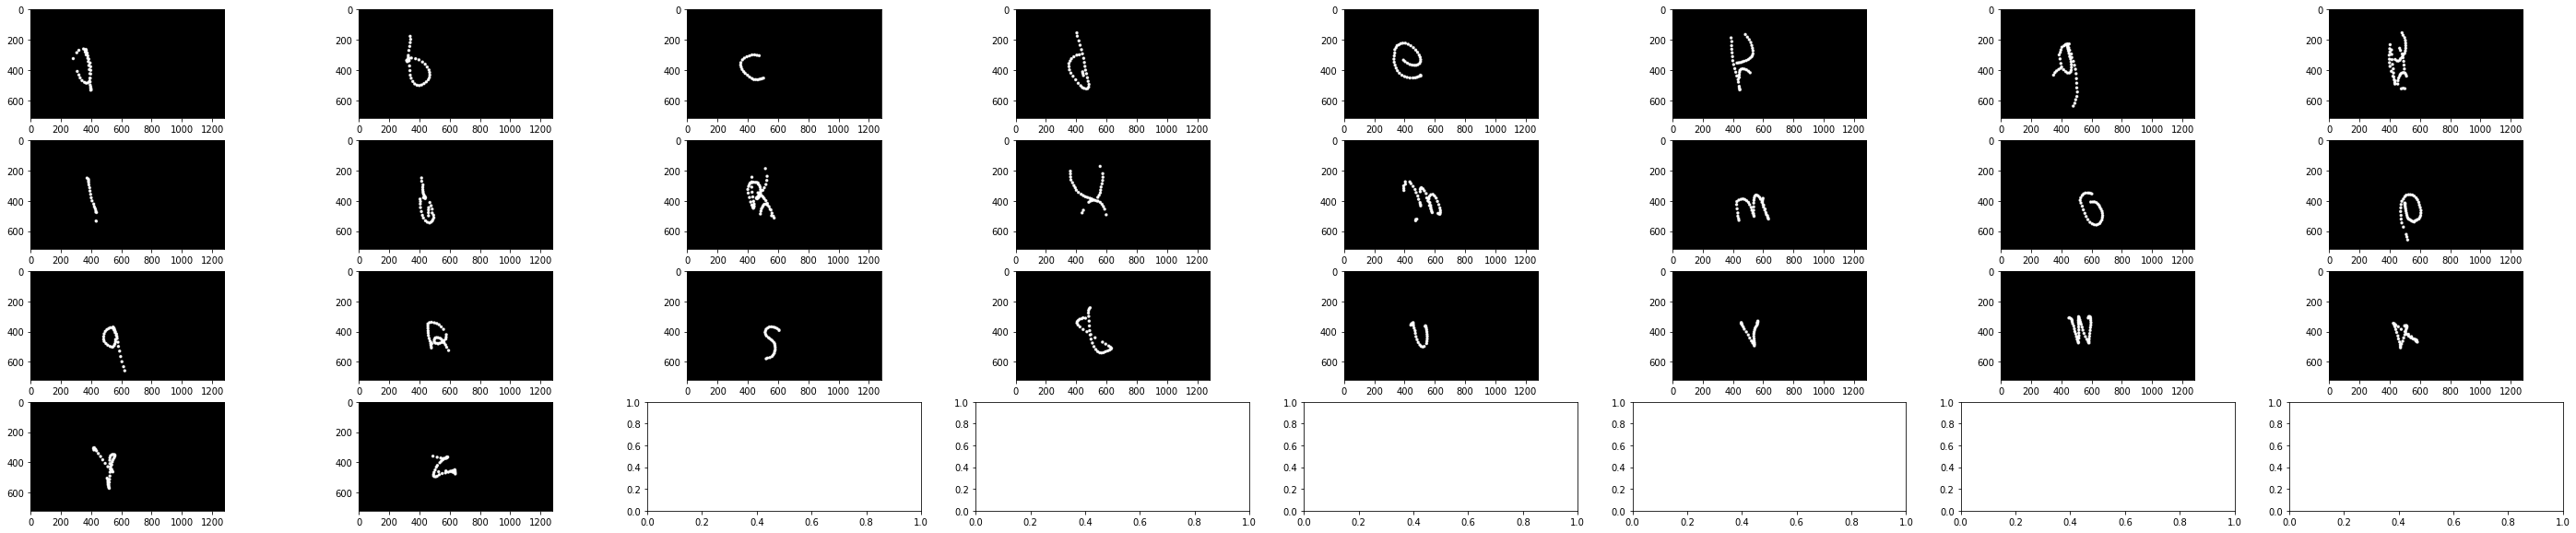

In [7]:
# Display of the individual letters
fig,axes = plt.subplots(4, 8, figsize=(50,10))

alphabet_reconstructions = {}

for i, markers in enumerate(list(alphabet_annot_split.values())):
    ax = axes[int(i/8),i%8]
    
    letter_reconstruction = np.zeros((height,width))
    x = np.arange(width)
    y = np.arange(height)
    marker_width = 10

    for point in markers:
        cx = point[0]
        cy = point[1]
        mask = (x[np.newaxis,:]-cx)**2 + (y[:,np.newaxis]-cy)**2 < marker_width**2
        letter_reconstruction[mask] = 255

    alphabet_reconstructions[list(alphabet_annot_split.keys())[i]] = letter_reconstruction
    ax.imshow(letter_reconstruction, cmap='gray')

### 1.3) Fitting to 28x28 tiles

In this step we standardize all the drawn letter into images or tiles of 28x28 pixels (like the training dataset for the NN we will use further). To do this, we first define the boundaries around the center of the pixels with a little margin, then we use a avg-pooling to fit it into 28x28 arrays

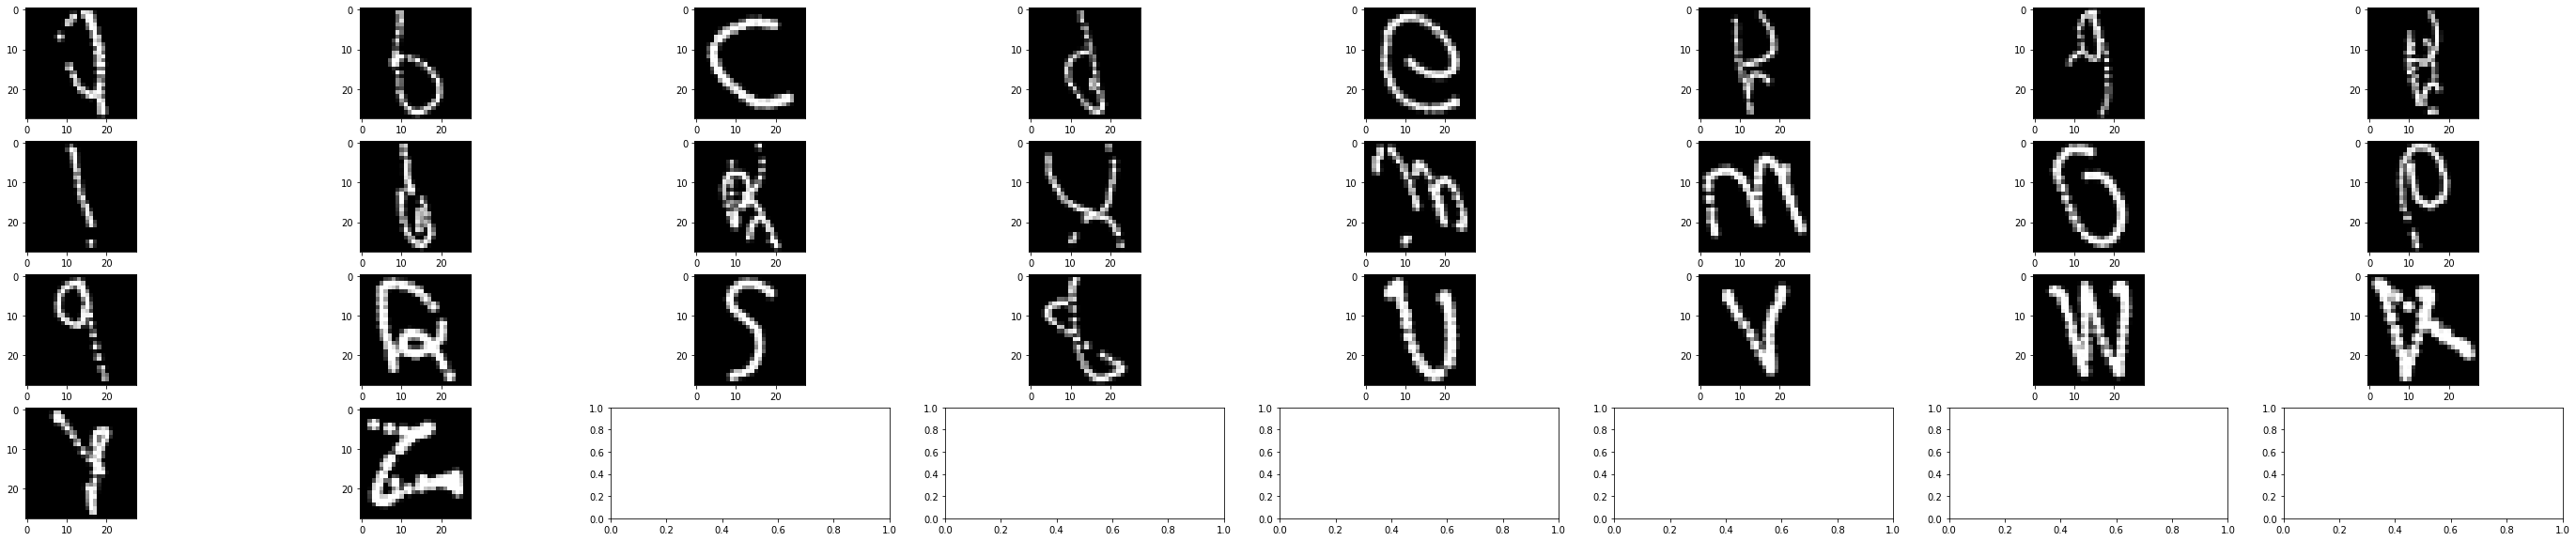

In [8]:
margin = 20
letter_tiles = {}

fig,axes = plt.subplots(4, 8, figsize=(50,10))
i = 0

for label, markers in alphabet_annot_split.items():
    ax = axes[int(i/8),i%8]
    i += 1
    
    (min_x, max_x) = min(markers[:,0]), max(markers[:,0])
    (min_y, max_y) = min(markers[:,1]), max(markers[:,1])
    
    delta_x = max_x - min_x
    delta_y = max_y - min_y
    
    mean_x = int((max_x + min_x) / 2)
    mean_y = int((max_y + min_y) / 2)
    
    width = max([delta_x, delta_y]) + margin
    width = 28 * (1 + np.round(width/28))
    dist_mean = int(width / 2)
    
    (edge_l, edge_r) = (mean_x + dist_mean, mean_x - dist_mean)
    (edge_t, edge_b) = (mean_y + dist_mean, mean_y - dist_mean)
    
    letter_rec_sq = alphabet_reconstructions[label][int(edge_b):int(edge_t),int(edge_r):int(edge_l)]
    
    letter_tiles[label] = skimage.measure.block_reduce(letter_rec_sq, int(width/28), np.mean)
    ax.imshow(letter_tiles[label], cmap='gray')

## 3) Letter prediction

Then we will train an model with the EMNIST dataset (dataset of handdrawn letters and digits) in order to predict the letters that were drawn.

### 3.1) Data preperation

In [9]:
# Retrieval of EMNITST data
data = pd.read_csv('emnist_data/emnist-byclass-train.csv', header=None).to_numpy()
print(data.shape)

(697932, 785)


In [10]:
# Retrieval of label-character mappings
label_mapping = np.genfromtxt('emnist_data/emnist-byclass-mapping.txt', delimiter=' ')

label_trans = {}
for label in label_mapping:
    label_trans[label[0]] = chr(int(label[1]))

In [11]:
# Splitting 100000 samples into training and validation datasets
train_data, test_data = train_test_split(data[:100000,:], train_size=0.8)

l


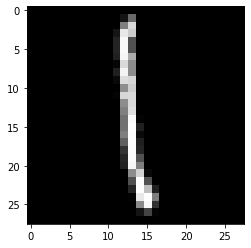

In [12]:
# Printing of 1 sample
img_nb = 150
print(label_trans[train_data[img_nb,0]])
plt.imshow(train_data[img_nb,1:].reshape(28,28).T, cmap='gray')
plt.show()

In [13]:
# Splitting labels (y) and image data (x)
train_x = train_data[:,1:]
train_y = train_data[:,0]

test_x = test_data[:,1:]
test_y = test_data[:,0]

# Normalization and reshaping
train_x = train_x / 255.0
test_x = test_x / 255.0

train_count = train_x.shape[0]
train_x = train_x.reshape(train_count, 28, 28, 1)

test_count = test_x.shape[0]
test_x = test_x.reshape(test_count, 28, 28, 1)

# Transform labels
num_classes = 63

train_y = tf.keras.utils.to_categorical(train_y, num_classes)
test_y = tf.keras.utils.to_categorical(test_y, num_classes)

### 3.2) Model definition and training

In [14]:
model = Sequential()    
    
# Creating conv layer 1
model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=[28, 28, 1]))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Dropout(0.25))

# Creating conv layer 2
model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.25))

# Adding the dense final part
model.add(Flatten())
model.add(Dense(1024, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                        

In [15]:
model_history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=10)

Epoch 1/10
2500/2500 [==============================] - 33s 10ms/step - loss: 0.7564 - accuracy: 0.7646 - val_loss: 0.5217 - val_accuracy: 0.8205
Epoch 2/10
2500/2500 [==============================] - 25s 10ms/step - loss: 0.5053 - accuracy: 0.8242 - val_loss: 0.4519 - val_accuracy: 0.8450
Epoch 3/10
2500/2500 [==============================] - 25s 10ms/step - loss: 0.4544 - accuracy: 0.8373 - val_loss: 0.4454 - val_accuracy: 0.8443
Epoch 4/10
2500/2500 [==============================] - 25s 10ms/step - loss: 0.4210 - accuracy: 0.8484 - val_loss: 0.4383 - val_accuracy: 0.8494
Epoch 5/10
2500/2500 [==============================] - 25s 10ms/step - loss: 0.3962 - accuracy: 0.8535 - val_loss: 0.4443 - val_accuracy: 0.8517
Epoch 6/10
2500/2500 [==============================] - 25s 10ms/step - loss: 0.3744 - accuracy: 0.8605 - val_loss: 0.4419 - val_accuracy: 0.8468
Epoch 7/10
2500/2500 [==============================] - 25s 10ms/step - loss: 0.3560 - accuracy: 0.8649 - val_loss: 0.4426 -

### 3.3) Analysis of the results of the model

In [16]:
model_train_acc = model_history.history['accuracy']
model_valid_acc = model_history.history['val_accuracy']
model_train_loss = model_history.history['loss']
model_valid_loss = model_history.history['val_loss']

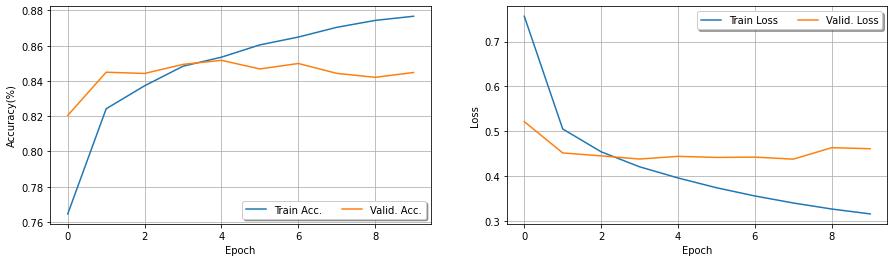

In [17]:
fig,(ax0,ax1) = plt.subplots(1, 2, figsize=(15,4))

# Accuracy graph
ax0.plot(model_train_acc, label="Train Acc.")
ax0.plot(model_valid_acc, label="Valid. Acc.")

ax0.set_xlabel('Epoch')
ax0.set_ylabel('Accuracy(%)')
ax0.legend(loc='lower right', fancybox=True, shadow=True, ncol=4)
ax0.grid()

# Loss graph
ax1.plot(model_train_loss, label="Train Loss")
ax1.plot(model_valid_loss, label="Valid. Loss")

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper right', fancybox=True, shadow=True, ncol=4)
ax1.grid()

We can see that the model reached lowest validation loss at epoch 3 with a corresponding accoracy of a little bit under 85%. As we can see from the loss graph, the model hasn't overfitted yet and kept a validation accuracy of around 85% consistently past epoch 3.

Now we can move on to try and predict what was drawn in the air.

### 3.4) Prediction on alphabet

- Expected "a"; Predicted: "2" (conf: 58.81%), "Q" (conf: 29.41%)


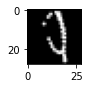

- Expected "b"; Predicted: "b" (conf: 72.63%), "5" (conf: 13.96%)


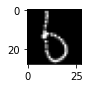

- Expected "c"; Predicted: "C" (conf: 99.99%), "c" (conf: 0.01%)


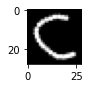

- Expected "d"; Predicted: "d" (conf: 52.76%), "6" (conf: 8.57%)


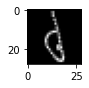

- Expected "e"; Predicted: "O" (conf: 69.41%), "Q" (conf: 17.54%)


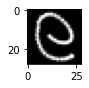

- Expected "f"; Predicted: "P" (conf: 30.98%), "p" (conf: 18.04%)


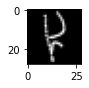

- Expected "g"; Predicted: "9" (conf: 89.15%), "F" (conf: 3.79%)


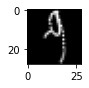

- Expected "h"; Predicted: "e" (conf: 14.93%), "d" (conf: 14.29%)


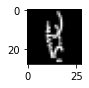

- Expected "i"; Predicted: "l" (conf: 72.27%), "1" (conf: 19.04%)


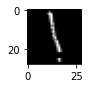

- Expected "j"; Predicted: "b" (conf: 62.65%), "6" (conf: 30.39%)


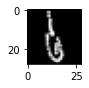

- Expected "k"; Predicted: "h" (conf: 32.80%), "K" (conf: 17.48%)


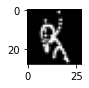

- Expected "l"; Predicted: "Y" (conf: 52.12%), "X" (conf: 33.83%)


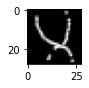

- Expected "m"; Predicted: "M" (conf: 70.14%), "n" (conf: 10.69%)


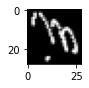

- Expected "n"; Predicted: "M" (conf: 99.81%), "m" (conf: 0.10%)


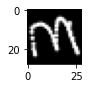

- Expected "o"; Predicted: "5" (conf: 93.81%), "g" (conf: 5.83%)


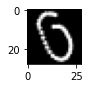

- Expected "p"; Predicted: "P" (conf: 96.65%), "p" (conf: 3.26%)


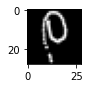

- Expected "q"; Predicted: "9" (conf: 99.68%), "q" (conf: 0.17%)


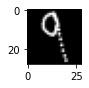

- Expected "r"; Predicted: "Q" (conf: 79.97%), "2" (conf: 13.52%)


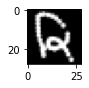

- Expected "s"; Predicted: "S" (conf: 75.09%), "5" (conf: 23.35%)


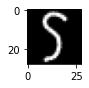

- Expected "t"; Predicted: "t" (conf: 88.36%), "r" (conf: 3.96%)


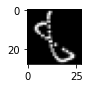

- Expected "u"; Predicted: "u" (conf: 48.80%), "U" (conf: 34.96%)


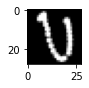

- Expected "v"; Predicted: "Y" (conf: 89.69%), "y" (conf: 9.07%)


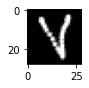

- Expected "w"; Predicted: "W" (conf: 47.46%), "N" (conf: 45.58%)


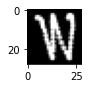

- Expected "x"; Predicted: "B" (conf: 46.87%), "X" (conf: 24.83%)


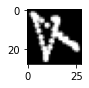

- Expected "y"; Predicted: "Y" (conf: 70.91%), "7" (conf: 26.33%)


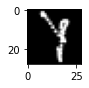

- Expected "z"; Predicted: "Z" (conf: 97.58%), "z" (conf: 1.53%)


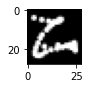

In [18]:
correct = []

for label, image in letter_tiles.items():
    x = image.reshape(1,28,28,1).T / 255.0
    
    res = model.predict(x).reshape(num_classes)
    res_ind = np.flip(np.argsort(res))
    
    if label == label_trans[res_ind[0]].lower():
        correct.append(label)
    
    print(f'- Expected "{label}"; Predicted: "{label_trans[res_ind[0]]}" (conf: {res[res_ind[0]]*100:.2f}%), "{label_trans[res_ind[1]]}" (conf: {res[res_ind[1]]*100:.2f}%)')
    plt.figure(figsize=(1,1))
    plt.imshow(image, cmap='gray')
    plt.show()

In [19]:
print(f'Correct percentage: {len(correct)*100/26:.2f}%')
print('Correct labels: ' + ', '.join([f'"{l}"' for l in correct]))

Correct percentage: 42.31%
Correct labels: "b", "c", "d", "m", "p", "s", "t", "u", "w", "y", "z"


### 3.5) Conclusion

The prediction on the letter I drew in the air is satisfying to me as I consider my drawing pretty messy and the my handwriting is also a bit confusing. But overall, if I had a higher quality video and paid more attention to how I drew the letters, it could lead to much better results.

## 4) Extending to a word

In order to extend to a word, I spelled out the letters in the air while going to the right so the letter don't overlap.

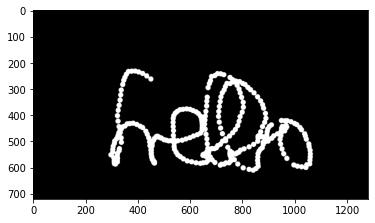

In [23]:
hello_annot = np.genfromtxt('Video_annotations/Annotation_hello_6.mp4_arnaud.csv', delimiter=',')[3:,1:]

# Video parameters
vid = cv2.VideoCapture('Videos/hello_arnaud.mp4')
height = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))

# Flipping the annotations in the right orientation
hello_annot  = (0, height) - hello_annot

# Displaying a concatenation of all the markers in one single image.
hello_reconstruction = np.zeros((height,width))
x = np.arange(width)
y = np.arange(height)
marker_width = 10

for point in hello_annot[:,:]:
    cx = point[0]
    cy = point[1]
    mask = (x[np.newaxis,:]-cx)**2 + (y[:,np.newaxis]-cy)**2 < marker_width**2
    hello_reconstruction[mask] = 255
    
plt.imshow(hello_reconstruction, cmap='gray')
plt.show()

Following this, I wanted to make use of the RCNN technique we have seen in class in to detect letters as object and predict the label once the region have been predicted using a RPN. It has not been implemented due to the complexity of adapting the datasets and building the networks and everything around them. But this is something that could be explored in the future as I believe it has good chances to work.

## 5) Conclusions

Using the feature tracking of Vision Tool was successfull and allowed to have good sequences of markers. These sequences of markers allowd to build images where we could well enough guess what the intended letter was. To verify this, I put the images to the test against a model trained on handwritten letters and numbers, where we managed to get about half of correct predictions. I consider this a success as the dataset was trained on letter that written using a medium that could make use of multiple segments, moreover, I would consider my handwriting poor to say the least and drawing in the air didn't help, which didn't help much the quality of the drawn letters.

To extend these techniques to words, I made the choice to draw the letters one next to the other to avoid overlaps and have one image with the full word. Following this we identified that based on the outputted picture, an object detection could be used to isolate and predict the various letters of the word. To do this object detection we could use techniques of RCNN like seen in lecture.